In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
import glasbey

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)

In [55]:
datapath = Path().cwd().parent / "data/interim/lightsheet"
import h5py

with h5py.File(datapath / "Recon_fused_tp_202_ch_0_probabilities.h5", "r") as f:
    print(f["exported_data"])
    data = f["exported_data"][:]
    
data = tifffile.imread(datapath / "Recon_fused_tp_202_ch_0_probabilities_convolved.tif")
data = np.expand_dims(data, -1)
    
with h5py.File(datapath / "Recon_fused_tp_100_ch_0_probabilities.h5", "r") as f:
    print(f["exported_data"])
    data2 = f["exported_data"][:]

<HDF5 dataset "exported_data": shape (371, 983, 415, 1), type "<u2">
<HDF5 dataset "exported_data": shape (371, 983, 415, 1), type "<u2">


In [59]:
data = data / np.quantile(data.max(), 0.99)
data2 = data2 / data2.max()

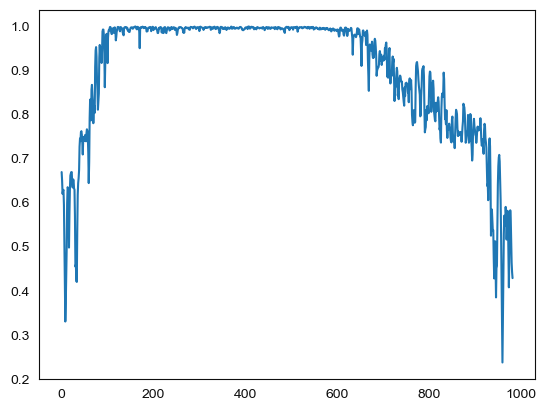

In [67]:
plt.plot(np.max(data, axis=(0, 2)))

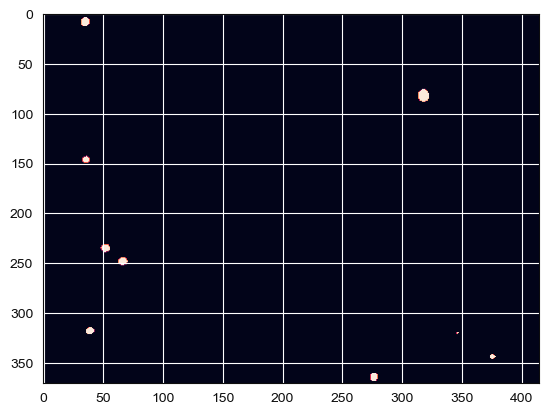

In [75]:
plt.imshow(data[:, 25, :, 0]>0.25, aspect="auto")

In [77]:
from circle_fit import lm, taubinSVD
from sklearn.cluster import DBSCAN
from scipy.stats import mode

def find_circle(pts):
    if len(pts) < 3:
        return (0, 0, 0)
    cluster = DBSCAN(eps=5, min_samples=5).fit(pts)
    maxlabel = [a[0] for a in Counter(cluster.labels_).most_common(4)]
    pts = pts[np.in1d(cluster.labels_, maxlabel)]
    
    if len(pts) < 3:
        return (0, 0, 0)
    x, z, r, sig = taubinSVD(pts)
    return x, z, r

def cirlce_meanip(vals, x, z, r, tol=20, bins=500):
    Z, X = np.meshgrid(np.arange(vals.shape[1]), np.arange(vals.shape[0]))
    mindis2, maxdis2 = (r - tol)**2, (r + tol)**2
    dis2 = (X - x)**2 + (Z - z)**2
    thresh = (dis2 > mindis2) & (dis2 < maxdis2)
    X, Z, vals = X[thresh], Z[thresh], vals[thresh]
    theta = np.arctan2(Z - z, X - x) + np.pi
    thetabins = np.floor(theta / (2*np.pi) *bins).astype(int)
    df = pd.DataFrame({"theta": thetabins, "vals": vals})
    series = pd.Series({i: 0.0 for i in range(bins)})
    series.update(df.groupby("theta")["vals"].mean())
    return np.array(series.astype(float).values)

def moving_median(vals, k):
    return np.array([np.median(vals[max(0, i-k):min(len(vals), i+k)]) for i in range(len(vals))])
    
c_list = []
ip_list = []
for d in [data, data2]:
    circs = [find_circle(np.argwhere(d[:, i, :, 0] > 0.3)) for i in tqdm(range(d.shape[1]))]
    k = 5
    circs = np.array(circs)    
    xs, zs, rs = moving_median(circs[:, 0], 10), moving_median(circs[:, 1], 10), moving_median(circs[:, 2], 10)
    ips = [cirlce_meanip(d[:, i, :, 0], xs[i], zs[i], rs[i]) for i in tqdm(range(d.shape[1]))]
    c_list.append(np.stack([xs, zs, rs], axis=1))
    ip_list.append(ips)


100%|██████████| 983/983 [00:18<00:00, 54.07it/s] 

100%|██████████| 983/983 [00:03<00:00, 293.61it/s]

100%|██████████| 983/983 [00:12<00:00, 81.91it/s] 

100%|██████████| 983/983 [00:03<00:00, 291.78it/s]


200 200


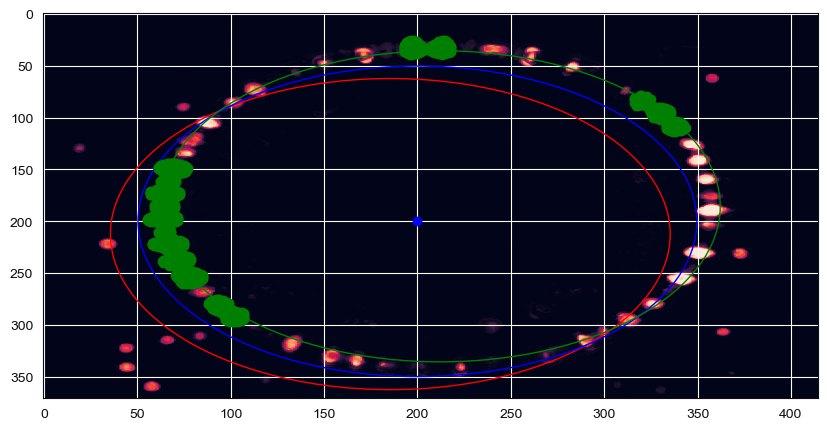

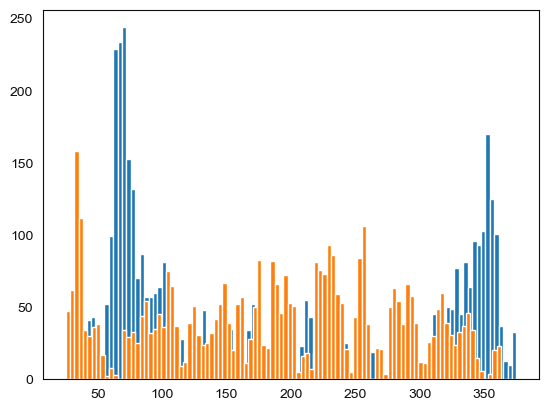

In [36]:
from collections import Counter
# plot one y slice with corresponding circle
i = 500
fig, ax = plt.subplots(figsize=(10, 5))
plt.imshow(data[:, i, :, 0], aspect="auto")
x, z, r = circs[i]
c = plt.Circle((x, z), r, color="r", fill=False)
ax.add_artist(c)
where = np.argwhere(data[:, i, :, 0] > 0.5)
z, x = 200, 200
print(z, x)
r = np.median(np.sqrt(((where - [z, x])**2).sum(1)))
c = plt.Circle((z, x), r, color="b", fill=False)
ax.add_artist(c)
plt.scatter(z, x, color="b")

cluster = DBSCAN(eps=5, min_samples=5).fit(where)
maxlabel = [a[0] for a in Counter(cluster.labels_).most_common(4)]
pts = where[np.in1d(cluster.labels_, maxlabel)]
plt.scatter(pts[:, 1], pts[:, 0], color="g")
x, z, r, sig = taubinSVD(pts)
c = plt.Circle((z, x), r, color="g", fill=False)
ax.add_artist(c)

plt.show()

plt.hist(where[:, 1], bins=100)
plt.hist(where[:, 0], bins=100)
plt.show()

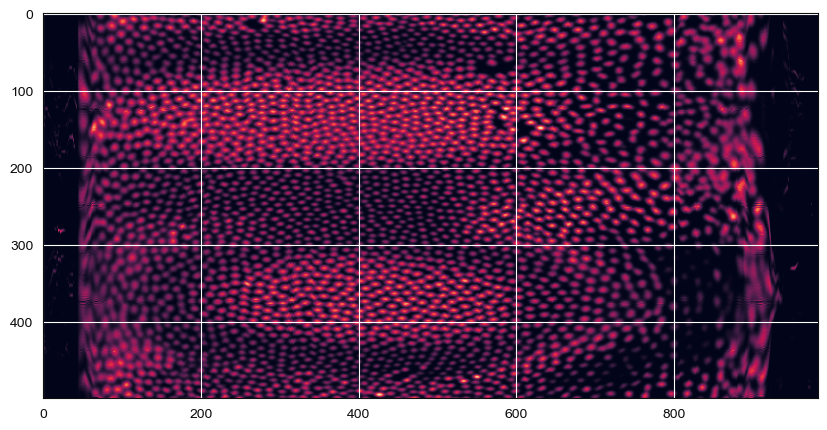

In [82]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.imshow(np.array(ip_list[0]).T, aspect="auto")

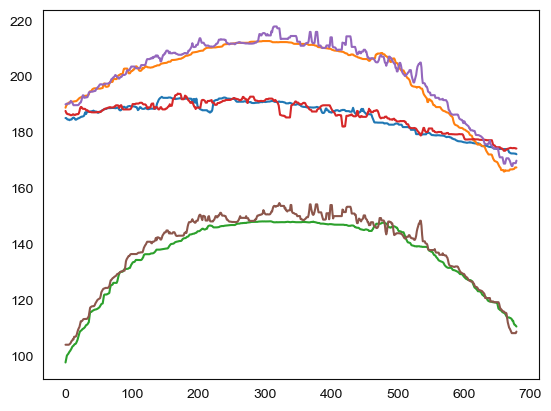

In [81]:
for circs in c_list:
    circs = np.array(circs)
    plt.plot(circs[120:800, 0])
    plt.plot(circs[120:800, 1])
    plt.plot(circs[120:800, 2])
plt.show()

In [85]:
import json
pts = json.load(open(r"D:\Tracking\NucleiTracking\circle_fit.json", "r"))
pts2 = json.load(open(r"D:\Tracking\NucleiTracking\circle_fit2.json", "r"))

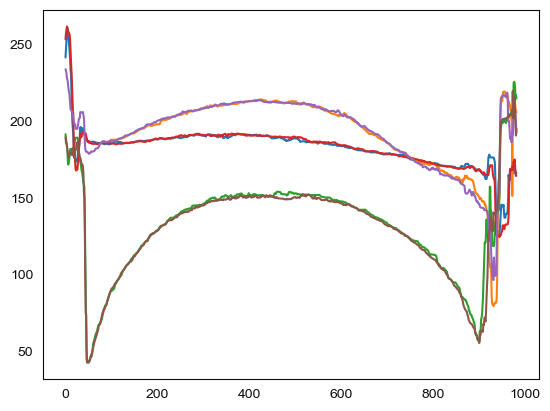

In [86]:
plt.plot(pts["x"])
plt.plot(pts["z"])
plt.plot(pts["r"])
plt.plot(pts2["x"])
plt.plot(pts2["z"])
plt.plot(pts2["r"])
plt.show()